<span style="color:red;font-size:1.5em;font-weight:bold;background-color:yellow">Partie 4 - Appliquer la méthode supervisée</span>

<span style="color:orange;font-size:1.5em;font-weight:bold">Cas supervisé + semi supervisé</span>

On va traité dans un premier temps un modèle supervisé puis on l'utilisera comme initialisation pour le SSL (remplace le cluster)

<span style="color:blue;font-size:1.2em;font-weight:bold">Mise en place</span>

In [1]:
# Module pour recharger un module sans redemarrer le kernel
# import importlib
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import os
import numpy as np
import pandas as pd
from pathlib import Path
import gc
import copy

# On utilise pytorch ici plutot que tensorflow
# Avantage: plus personnalisable VS Plus facile a utiliser 
# Définit les tenseurs, couches de neurones et algo d'opti (SGD,Adam)
import torch
import torch.nn as nn
import torch.optim as optim
# Pour créer une structure pour lire les images et les envoyer par paquet (batches) au GPU
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split



In [3]:
# Sert à éviter les Warnings avec les transformations sur des vues en transformant 
# ces warning en erreur obligeant ainsi à ne travailler que sur des copies ou les originaux.

pd.set_option('mode.chained_assignment','raise')

In [4]:
# Ajoute le dossier datas_manipulation au sys.path. Remarque ne pas oublier le __init__.py dans le dossier datas_manipulation
import sys
# root_path = Path(__file__).resolve().parents[1] # Ne fonctionne pas sur notebook
ROOT_PATH = Path.cwd().parent
sys.path.append(str(ROOT_PATH))

In [5]:
# Fonctions personnelles

from notebooks.utils.dataset import BaseTransform, ImagesToDataset
from notebooks.utils.models import BrainCancerClassifier
from notebooks.utils.training import Trainer, SslManager
from notebooks.utils.data_manipulation import get_score
from notebooks.utils.plotting.make_model_plots import plot_confusion_matrix


In [6]:
# Variables/paramètres globales

# Création dossier results
SAVE_PATH = ROOT_PATH.joinpath('datas/results')
Path.mkdir(SAVE_PATH,exist_ok = True)

# Pour la reproductibilité (similaire a random_state) 
# --> influence l'initialisation des poids ResNet et le mélange du DataLoader
torch.manual_seed(42)
np.random.seed(42)

# Config pour basculer sur le GPU si possible (50x plus rapide en deep learning que CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")
# Taille des paquets (en puissance de 2 pour s'aligner avec l'archi GPU: 2 4 8 16 32 64)
BATCH_SIZE = 16

# Config des images
IMG_SIZE = 224 # Résolution standard 
# Cas transfer learning avec ResNet: Les valeurs données sont les moyennes et ecarts type des 
# couleurs RGB dans ImageNet
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

RANDOM_STATE=42
N_JOBS=-1
# N_FEATURES = 512 # Nombre de features issu des CNN,en 18,34 couches on a 512 features, 
# # en 50,101 et 152 on passe a 2048 features, avec VGG16 on est 4096 
# # et pour EfficientNet-BO c'est 1280 features
TEST_SIZE = 0.2
N_EPOCH = 10
EXPERIMENT_NAME = "experiment_01"

Running on: cpu


In [7]:
# Dictionnaire de la confinguration globale du projet
project_config = {
    "model":"resnet18",
    # "n_features":N_FEATURES,
    "n_jobs":N_JOBS,
    "batch":BATCH_SIZE,
    "device":str(DEVICE),
    "img_size":IMG_SIZE,
    "img_mean":IMG_MEAN,
    "img_std":IMG_STD,
    "test_size":TEST_SIZE,
    "random_state":RANDOM_STATE,
}

In [8]:
# Chemin des données brutes
DATAS_PATH = ROOT_PATH/"datas/raw/mri_dataset_brain_cancer_oc"

# Listing des fichiers qui composent les labellisés des non labellisés
# glob pour les fichiers et rglob si il y a des sous-dossiers
avec_labels_path = list((DATAS_PATH / "avec_labels").rglob("*.jpg"))
sans_label_path = list((DATAS_PATH / "sans_label").glob("*.jpg"))
project_config.update({"avec_label":len(avec_labels_path),"sans_label":len(sans_label_path)})

# Encodage des labels (0: normal, 1: cancer, -1: sans_label)
avec_labels_encoding = [1 if "cancer" in path.parts else 0 for path in avec_labels_path]
all_paths = avec_labels_path + sans_label_path
all_labels = avec_labels_encoding + ([-1] * len(sans_label_path))


<span style="color:blue;font-size:1.5em;font-weight:bold;background-color:yellow">Entrainement supervisée: Entrainer seulement sur le jeu fortement labellisé</span>

La méthode supervisée revient à faire de la classification en guidant le modèle via les images labellisées

- X sera donc composé des chemins des images (Series!) et y sera formé par les labels.
- On se constitue un jeu d'entrainement augmenté et un jeu de validation
- On créé les loaders
- On entraine le modèle en relevant les métriques d'intérêt

<span style="color:purple;font-weight:bold">Entrainement supervisé</span>

In [9]:
# gestionnaire de sauvegarde
supervised_manager = SslManager(
    EXPERIMENT_NAME,
    root_path=SAVE_PATH,
    extension_path="supervised"
)

In [10]:
supervised_config = project_config | {
    "num_classes":1,
    "supervised_n_epoch":N_EPOCH,
    "supervised_learning_rate":1e-4,
}

In [11]:
# juste par confort
X = avec_labels_path
y = avec_labels_encoding

# Train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=TEST_SIZE, 
    stratify=y, 
    random_state=RANDOM_STATE
)

In [12]:
# Datasets & Loaders

# Instanciation de l'objet de redim, norm, augmentation
base_transform = BaseTransform(mean=IMG_MEAN,std=IMG_STD,size=IMG_SIZE)

# Constitution des sets d'entrainement augmentés et de validation non augmenté
train_dataset = ImagesToDataset(X_train, y_train, transform=base_transform.preproc(train=True))
test_dataset = ImagesToDataset(X_test, y_test, transform=base_transform.preproc(train=False))

# Loader des sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
# Instanciation du modèle et configuration de la pipeline d'entrainement

# Instanciation du classificateur + déplacement sur le device
model_classif = BrainCancerClassifier(
    num_classes=1, 
    model_name=supervised_config['model']
).to(DEVICE)
# L'optimiseur ajuste les poids du modèle. Contient le learning_rate et les gradients.
# On met un learning rate (lr) faible car fine-tuning 
# (on ne veut pas détruire ce que ResNet sait déjà).
optimizer = optim.Adam(
    model_classif.parameters(), 
    lr=supervised_config["supervised_learning_rate"]
)
# On instancie la loss (sans poids car dataset équilibré)
# criterion = nn.BCELoss() # Avec SIGMOID on prefere passer a logit
# on a 50 images saines et 50 cancer du coup pos_weight ici vaut 1 mais en
# supposant une répartition plus commune (plus de sain que non)
num_sains = y_train.count(0)
num_cancers = y_train.count(1)
# Calcul du ratio (poids pour la classe positive)
# On ajoute 1e-6 pour éviter la division par zéro si le modèle ne trouve aucun cancer
pos_weight = torch.tensor([num_sains / (num_cancers + 1e-6)]).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Instanciation de la pipeline de training
trainer = Trainer(
    model_classif, 
    DEVICE, 
    criterion, 
    optimizer
)

In [14]:
# Boucle d'entraînement
temp_best_f2 = 0.0
temp_best_prauc = 0.0
temp_best_ece = 1.0
temp_best_score = get_score(temp_best_f2,temp_best_ece,temp_best_prauc,mode = "supervised")

print("====== Entraînement Supervisé (100 images) ==========")
for epoch in range(supervised_config['supervised_n_epoch']):
    # ================= ENTRAINEMENT ================
    train_loss = trainer.train_epoch(train_loader) # on entraine sur le 80 images labellisées
    
    # ====================== EVAL =====================
    results = trainer.eval_metrics(test_loader) # on evalue sur les 20 images restantes label
    ece = trainer.calculate_ece(results['raw_data']) #type:ignore On estime la fiabilité de la confiance
    print(
        f"Epoch {epoch+1}/{supervised_config['supervised_n_epoch']} | Loss: {train_loss:.4f}"
        f" | f2: {results["f2"]:.4f} | pr_auc: {results["pr_auc"]:.4f} | ece: {ece:.4f}"
    )
    
    # ================= SAUVEGARDE INDIVIDUELLE DES MÉTRIQUES =============
    temp_metrics ={
            "epoch" : epoch+1,
            "train_loss" : train_loss,
            # "f2" : results["f2"],
            # "precision" : results["precision"],
            # "recall":results["recall"],
            "ece":ece, # Fiabilité de la confiance du modèle
            # "accuracy": results["accuracy"], # Exactitude
            # "auc": results["auc"],# Capacité a séparer les labels
            # "pr_auc": results["pr_auc"], # Précision sur les positifs
            **{key: value for key, value in results.items()}
        }
    supervised_manager.log_metrics(temp_metrics)
    
    # ================ CHECKPOINT (SAVE SI MEILLEUR MODELE JUSQU'ICI) ===========
    temp_f2 = results["f2"]
    temp_prauc = results['pr_auc']
    temp_score = get_score(temp_f2,ece,temp_prauc,mode = "supervised")
    
    if temp_score >= temp_best_score:
    # if (temp_prauc >= temp_best_prauc) or (temp_f2 >= temp_best_f2):
    #     if ece <= temp_best_ece*1.25:
            
        # réalise un checkpoint
        supervised_manager.save_checkpoint({
            'epoch': epoch + 1,
            'train_loss':train_loss,
            'state_dict': model_classif.state_dict(), # ou plus rigoureux: trainer.model.state_dict()
            'optimizer': optimizer.state_dict(),# ou plus rigoureux: trainer.optimizer.state_dict()
            'f2': temp_f2,
            'pr_auc': temp_prauc,
            "ece":ece,
            'config': supervised_config
        },is_best=True)
        
        # MAJ des métriques
        # temp_best_f2 = max(temp_f2, temp_best_f2)
        temp_best_f2 = temp_f2
        temp_best_prauc = temp_prauc
        temp_best_ece = ece
        temp_best_score = temp_score

====== Entraînement Supervisé (100 images) ==========
Epoch 1/10 | Loss: 0.6902 | f2: 0.4444 | pr_auc: 0.7665 | ece: 0.0991
Epoch 2/10 | Loss: 0.6277 | f2: 0.6383 | pr_auc: 0.9049 | ece: 0.2088
Epoch 3/10 | Loss: 0.5791 | f2: 0.8491 | pr_auc: 0.9588 | ece: 0.1926
Epoch 4/10 | Loss: 0.5737 | f2: 0.8491 | pr_auc: 0.9625 | ece: 0.3995
Epoch 5/10 | Loss: 0.4990 | f2: 0.9184 | pr_auc: 0.9625 | ece: 0.2867
Epoch 6/10 | Loss: 0.4896 | f2: 0.9184 | pr_auc: 0.9667 | ece: 0.3219
Epoch 7/10 | Loss: 0.4471 | f2: 0.9184 | pr_auc: 0.9714 | ece: 0.3466
Epoch 8/10 | Loss: 0.4267 | f2: 0.9184 | pr_auc: 0.9714 | ece: 0.3203
Epoch 9/10 | Loss: 0.4333 | f2: 0.9184 | pr_auc: 0.9714 | ece: 0.2938
Epoch 10/10 | Loss: 0.3932 | f2: 0.9184 | pr_auc: 0.9714 | ece: 0.2694


**remarque**:
- temp_metrics sert a alimenter les manager (supervised, unsupervised...), il permet d'avoir un historique rapide et léger des métriques
- save_checkpoint lui va sauvegarder le gros de la structure afin de pouvoir recharger et/ou analysr le modèle par la suite, il est lourd et doit donc être correctement structuré. On y sauvegarde:
    - les poids pour le classificateur (state_dict)
    - l'état de l'optimiseur
    - la performance de référence (quelques métriques pour l'identifier, epoch/f2/pr_auc/ece)
    - la configuration

In [15]:
# ============== MEILLEUR MODELE POUR AFFICHAGE METRIQUES ===========
# On recharge le meilleur état trouvé pour la suite (SSL)
model_path = supervised_manager.ckpt_dir / "best_model.pth"
checkpoint = torch.load(model_path)
model_classif.load_state_dict(checkpoint['state_dict'])
print(f"Meilleur modèle chargé - epoch: {checkpoint['epoch']} | f2: {checkpoint['f2']:.4f}"
    f"| pr_auc: {checkpoint['pr_auc']:.4f} | ece: {checkpoint['ece']:.4f}")

Meilleur modèle chargé - epoch: 10 | f2: 0.9184| pr_auc: 0.9714 | ece: 0.2694


f2 et pr_auc augmentent rapidement mais ece croit aussi très fortement passant de 0.1 a 0.3, l'algorithme faisant un scoring basé sur ces métriques, on trouve que le meilleur modèle obtenu est à l'epoch 10 bien que l'epoch ait été multiplié par 2.5. Bien que f2 et pr auc soient très bon, l'ece traduit le fait que ces scores ne reflètent pas bien la réalit, le modèle est trop confiant.

In [16]:
# =============== NETTOYAGE ===============
del (train_dataset, test_dataset, train_loader,
    train_loss, results
)
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

<span style="color:purple;font-weight:bold">Entrainement Semi Supervisée: Pseudo labelling sur les images inconnues</span>

In [17]:
# gestionnaire de sauvegarde
ssl_manager = SslManager(
    EXPERIMENT_NAME,
    root_path=SAVE_PATH,
    extension_path="ssl"
)

In [18]:
# Me^me pre traitement sur les données non labellisées (pas de split ni d'augment evidemment)
Xu = sans_label_path
yu = [-1]*len(sans_label_path)
# dataset et loader
udataset = ImagesToDataset(Xu, yu, transform=base_transform.preproc(train=False))
uloader = DataLoader(udataset, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
# La mise en place globale du pseudo labelling
counter = 0
max_pseudo_iteration = 10
reset = True # Si on repart d'une pipeline neuve (Cold start) ou pas (Continous Fine Tuning)
# Cold start permet d'eviter l'accumulation d'erreurs et l'oubli (stacker les biais et 
# oublier les fortement labellisés) MAIS coût d'entrainement plus elevé

# Garde fou pour éviter dérive
temp_best_f2 = checkpoint['f2'] # On repart du f2 de la baseline (supervisée)
temp_best_prauc = checkpoint['pr_auc'] # On repart de l'aucpr de la baseline (supervisée)
temp_best_ece = checkpoint['ece']
temp_best_score = get_score(temp_best_f2,temp_best_ece, temp_best_prauc)
ece = checkpoint['ece']
del checkpoint
gc.collect()
best_trainer_state = copy.deepcopy(trainer.model.state_dict())
stop = 0
max_stop = 5

In [20]:
ssl_config = supervised_config | {
    "reset":reset,
    "max_pseudo_iter":max_pseudo_iteration,
    "ssl_learning_rate":1e-5,
    "init_threshold":0.95,
    "final_threshold":0.85,
    'ssl_n_epoch':N_EPOCH,
}

ssl_manager.save_config(ssl_config)

# # décroissance du threshold, on assoupli le threshold a mesure des iterations
decay = np.linspace(
    ssl_config["init_threshold"]-0.1,
    ssl_config["final_threshold"]-0.05,
    max_pseudo_iteration+1
)


In [21]:
while counter <= max_pseudo_iteration:
    # On s'assure que le threshold est bon
    trainer.threshold = decay[counter]
    
    # ======== PRÉDICTION SUR SET INCONNU ET GET DES PSEUDO LABELS/PATHS =========
    # IMPORTANT: AVANT D'ETRE ECRASE, ON RECOLTE PSEUDO_X ET Y! CE N'EST PAS ULOADER QUI DOIT
    # ETRE MAJ MAIS TRAINER QUI SERA MODIFIE (NOUVEAU PSEUDO_X ET PSEUDO_Y) AVANT SON RESET.
    # MODEL_CLASSIF ET OPTIMIZER DE LA PARTIE SUPERVISÉE ONT POUR SEULE UTILITÉ INFLUENCÉ TRAINER
    print(f"=== iter {counter} | pseudo labelling (seuil {decay[counter]:.4f}) ===")
    pseudo_X, pseudo_y = trainer.pseudo_labels(uloader)
    print(f"Pseudo-labels générés : {len(pseudo_X)}")
    
    # ============= EMPECHE BOUCLE INUTIE ET DERIVE IMPORTANTE =================
    if len(pseudo_X) == 0 or ece >= 0.5: # Ajout de l'ece pour eviter le biais de confirmation
        print("Confiance rompue pour relancer l'entrainement")
        break
    
    
    # ========== MISE EN PLACE DU DATALOADER ================ 
    # (On NE STACK PAS les pseudo et on REPART TOUJOURS du jeu labellisé de base!)
    new_X_train = X_train + [Path(x) for x in pseudo_X]
    new_y_train = y_train + pseudo_y
    
    # dataset et loader, on applique des transformations et shuffle. Pour corser le travail et
    # rendre l'entrainement plus efficace, on applique ici des transformations FORTES VS FAIBLE
    # pour le train du supervisée
    new_train_dataset = ImagesToDataset(
        new_X_train,
        new_y_train,
        transform=base_transform.preproc(train=True,strong_augment=True)
    )
    new_train_loader = DataLoader(
        new_train_dataset,
        BATCH_SIZE,
        shuffle=True
    )
    
    # =================== REGUL PONDERATION DU CRITERION =================
    # Si les pseudo labels déséquilibrent trop le jeu d'entrainement, il faut reponderer criterion
    # Compter les occurrences dans le nouveau set d'entraînement
    num_sains = new_y_train.count(0)
    num_cancers = new_y_train.count(1)
    # Calcul du ratio (poids pour la classe positive)
    # On ajoute 1e-6 pour éviter la division par zéro si le modèle ne trouve aucun cancer
    new_pos_weight = torch.tensor([num_sains / (num_cancers + 1e-6)]).to(DEVICE)
    new_criterion = nn.BCEWithLogitsLoss(pos_weight=new_pos_weight)
    
    # ================ MISE EN PLACE DU TRAINER =========================
    if reset:
        # ============ COLD START ==============
        # NEW START, on repart d'un nouveau modele et nouvel optimiseur (et entrainement)
        # ========================= Cleaning ================
        if 'new_trainer' in locals():
            del new_model_classif, new_optimizer, new_trainer
            gc.collect() # Libère la RAM CPU
            if torch.cuda.is_available():
                torch.cuda.empty_cache() # Libère la VRAM GPU
        # =========================================
        # CHARGEMENT DES POIDS DU MEILLEUR MODÈLE PRÉCÉDENT
        new_model_classif = BrainCancerClassifier(
            num_classes=1,
            model_name=supervised_config['model']
        ).to(DEVICE)
        new_model_classif.load_state_dict(copy.deepcopy(best_trainer_state))
        
        new_optimizer = optim.Adam(
            new_model_classif.parameters(), 
            lr=ssl_config["ssl_learning_rate"]
        )
        # new_criterion = nn.BCELoss() # Avec SIGMOID on prefere passer a logit + label smoothing
        new_trainer = Trainer(
            new_model_classif, 
            DEVICE, 
            new_criterion, 
            new_optimizer, 
            threshold=decay[counter]
        )
    else:
        # ============ CONTNOUS FINE TUNING ============
        # ON GARDE LE MEME TRAINER, REDUCTION SEUIL + LEARNING_RATE pour ne pas détruire 
        # les poids déjà appris.
        new_trainer = trainer
        new_trainer.threshold = decay[counter] # MAJ threshold
        new_trainer.criterion.pos_weight = new_pos_weight # MAJ Pondération
        # La boucle est obligatoire pour modifier le LR dans PyTorch
        for param_group in new_trainer.optimizer.param_groups:
            param_group['lr'] = ssl_config["ssl_learning_rate"] / 10
    
    # =============== ENTRAINEMENT ====================================
    IMPROVED_FLAG = False
    print(f"====== iter {counter} | seuil {decay[counter]:.4f} | {len(new_X_train)} images =======")
    for epoch in range(ssl_config['ssl_n_epoch']):
        train_loss = new_trainer.train_epoch(new_train_loader) # le nouveau set de train
        # ====================== EVAL =====================
        results = new_trainer.eval_metrics(test_loader) # ON RESTE SUR LE MEME SET D'EVAL!
        ece = new_trainer.calculate_ece(results['raw_data'])# type:ignore
        print(f"Epoch {epoch+1}/{ssl_config['ssl_n_epoch']} | Loss: {train_loss:.4f} | f2: {results["f2"]:.4f} | pr_auc: {results["pr_auc"]:.4f} | ece: {ece:.4f}")
        # =============== CHECKPOINT =====================================
        temp_metrics = {
            "epoch":epoch+1,
            "iteration":counter,
            "threshold":decay[counter],
            "n_pseudo":len(pseudo_X),
            "train_loss":train_loss,
            "ece":ece, # Fiabilité de la confiance du modèle
            **{key: value for key, value in results.items()}
        }
        ssl_manager.log_metrics(temp_metrics)
        
        temp_f2 = results['f2']
        temp_prauc = results['pr_auc']
        temp_score = get_score(temp_f2,ece,temp_prauc)

        if temp_score > temp_best_score:
        # if (temp_prauc >= temp_best_prauc) or (temp_f2 >= temp_best_f2):
        #     if temp_ece <= temp_best_ece:
            # On sauvegarde l'état du modèle et les pseudos qui ont fonctionné
            # best_trainer_state = copy.deepcopy(new_trainer.model.state_dict())
            # Moins gourmand en RAM
            best_trainer_state = {
                key: value.cpu().clone() for key, value 
                in new_trainer.model.state_dict().items()
            }
            
            temp_best_f2 = temp_f2
            # QUE pour le checkpoint!
            temp_best_prauc = temp_prauc
            IMPROVED_FLAG = True
            temp_best_ece = ece
            temp_best_score = temp_score
            
            ssl_manager.save_checkpoint({
                'epoch':epoch+1,
                'iteration':counter,
                'threshold':decay[counter],
                'n_pseudo':len(pseudo_X),
                'train_loss':train_loss,
                'confusion_matrix':temp_metrics['confusion_matrix'],
                # new_model_classif.state_dict() == new_trainer.model.state_dict() 
                # donc on peut raccourcir ici car pointent au même objet en mémoire
                'state_dict': new_model_classif.state_dict(), 
                # new_optimizer.state_dict(), si pas de cold start: plante car n'existe pas
                'optimizer': new_trainer.optimizer.state_dict(),
                'f2': temp_best_f2,
                'pr_auc': temp_best_prauc,
                'ece':temp_best_ece,
                'config': ssl_config
            }, is_best=True)
            ssl_manager.save_weak_labels(pseudo_X, pseudo_y)
                
    if not IMPROVED_FLAG: # On a fait la boucle d'entrainement mais pas d'amélioration sur l'iteration
        # ============= CAS LAMBDA =============
        # Rollback : on recharge les poids du meilleur modèle dans le trainer actuel
        new_trainer.model.load_state_dict(best_trainer_state)
        stop+=1
    else:
        stop = 0 # on reinitialise le compteur de stagnation
    if stop >= max_stop:
        print('Arrêt prématuré, plus de progression')
        break
    
    trainer = new_trainer
    counter+=1
    
    # ========================= Cleaning ================
    # Nettoyage de fin d'itération
    del new_train_loader
    gc.collect()
    if torch.cuda.is_available():
            torch.cuda.empty_cache() # Libère la VRAM GPU
# =========================================

=== iter 0 | pseudo labelling (seuil 0.8500) ===


Pseudo-labeling: 100%|██████████| 88/88 [01:19<00:00,  1.10it/s]


Pseudo-labels générés : 22
====== iter 0 | seuil 0.8500 | 102 images =======
Epoch 1/10 | Loss: 0.5206 | f2: 0.9184 | pr_auc: 0.9833 | ece: 0.2489
Epoch 2/10 | Loss: 0.5427 | f2: 0.9184 | pr_auc: 0.9769 | ece: 0.2696
Epoch 3/10 | Loss: 0.5166 | f2: 0.9184 | pr_auc: 0.9769 | ece: 0.2260
Epoch 4/10 | Loss: 0.5068 | f2: 0.9184 | pr_auc: 0.9833 | ece: 0.2234
Epoch 5/10 | Loss: 0.4903 | f2: 0.9184 | pr_auc: 0.9769 | ece: 0.2183
Epoch 6/10 | Loss: 0.4848 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2203
Epoch 7/10 | Loss: 0.4928 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2174
Epoch 8/10 | Loss: 0.4742 | f2: 0.8333 | pr_auc: 0.9833 | ece: 0.2166
Epoch 9/10 | Loss: 0.5124 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2195
Epoch 10/10 | Loss: 0.5216 | f2: 0.9184 | pr_auc: 0.9769 | ece: 0.2862
=== iter 1 | pseudo labelling (seuil 0.8450) ===


Pseudo-labeling: 100%|██████████| 88/88 [01:18<00:00,  1.12it/s]


Pseudo-labels générés : 119
====== iter 1 | seuil 0.8450 | 199 images =======
Epoch 1/10 | Loss: 0.3207 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2365
Epoch 2/10 | Loss: 0.3119 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2432
Epoch 3/10 | Loss: 0.3147 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2438
Epoch 4/10 | Loss: 0.3136 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2136
Epoch 5/10 | Loss: 0.3014 | f2: 0.7447 | pr_auc: 0.9769 | ece: 0.2338
Epoch 6/10 | Loss: 0.2887 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2555
Epoch 7/10 | Loss: 0.3065 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2245
Epoch 8/10 | Loss: 0.3037 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2500
Epoch 9/10 | Loss: 0.2896 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2471
Epoch 10/10 | Loss: 0.3121 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2682
=== iter 2 | pseudo labelling (seuil 0.8400) ===


Pseudo-labeling: 100%|██████████| 88/88 [01:14<00:00,  1.18it/s]


Pseudo-labels générés : 122
====== iter 2 | seuil 0.8400 | 202 images =======
Epoch 1/10 | Loss: 0.3324 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2906
Epoch 2/10 | Loss: 0.3234 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2441
Epoch 3/10 | Loss: 0.3345 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2301
Epoch 4/10 | Loss: 0.3291 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2502
Epoch 5/10 | Loss: 0.3190 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2498
Epoch 6/10 | Loss: 0.3307 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2482
Epoch 7/10 | Loss: 0.3149 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2207
Epoch 8/10 | Loss: 0.2955 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2221
Epoch 9/10 | Loss: 0.3381 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2189
Epoch 10/10 | Loss: 0.3106 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2162
=== iter 3 | pseudo labelling (seuil 0.8350) ===


Pseudo-labeling: 100%|██████████| 88/88 [01:15<00:00,  1.16it/s]


Pseudo-labels générés : 137
====== iter 3 | seuil 0.8350 | 217 images =======
Epoch 1/10 | Loss: 0.3231 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2242
Epoch 2/10 | Loss: 0.3438 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2236
Epoch 3/10 | Loss: 0.3519 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2347
Epoch 4/10 | Loss: 0.3199 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2395
Epoch 5/10 | Loss: 0.3399 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2296
Epoch 6/10 | Loss: 0.3191 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2344
Epoch 7/10 | Loss: 0.3226 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2026
Epoch 8/10 | Loss: 0.3337 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2159
Epoch 9/10 | Loss: 0.3256 | f2: 0.7447 | pr_auc: 0.9769 | ece: 0.2250
Epoch 10/10 | Loss: 0.3392 | f2: 0.7447 | pr_auc: 0.9769 | ece: 0.2159
=== iter 4 | pseudo labelling (seuil 0.8300) ===


Pseudo-labeling: 100%|██████████| 88/88 [01:14<00:00,  1.18it/s]


Pseudo-labels générés : 156
====== iter 4 | seuil 0.8300 | 236 images =======
Epoch 1/10 | Loss: 0.3395 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2430
Epoch 2/10 | Loss: 0.3396 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2377
Epoch 3/10 | Loss: 0.3292 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2384
Epoch 4/10 | Loss: 0.2963 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2253
Epoch 5/10 | Loss: 0.3269 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2235
Epoch 6/10 | Loss: 0.3246 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2277
Epoch 7/10 | Loss: 0.3132 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.1961
Epoch 8/10 | Loss: 0.3283 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2038
Epoch 9/10 | Loss: 0.3178 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2171
Epoch 10/10 | Loss: 0.3329 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2347
=== iter 5 | pseudo labelling (seuil 0.8250) ===


Pseudo-labeling: 100%|██████████| 88/88 [01:15<00:00,  1.16it/s]


Pseudo-labels générés : 177
====== iter 5 | seuil 0.8250 | 257 images =======
Epoch 1/10 | Loss: 0.3479 | f2: 0.8333 | pr_auc: 0.9833 | ece: 0.2396
Epoch 2/10 | Loss: 0.3596 | f2: 0.8333 | pr_auc: 0.9667 | ece: 0.2223
Epoch 3/10 | Loss: 0.3163 | f2: 0.8333 | pr_auc: 0.9667 | ece: 0.2409
Epoch 4/10 | Loss: 0.3183 | f2: 0.7447 | pr_auc: 0.9769 | ece: 0.2443
Epoch 5/10 | Loss: 0.3312 | f2: 0.7447 | pr_auc: 0.9833 | ece: 0.2212
Epoch 6/10 | Loss: 0.3200 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2410
Epoch 7/10 | Loss: 0.3212 | f2: 0.7447 | pr_auc: 0.9769 | ece: 0.2338
Epoch 8/10 | Loss: 0.3237 | f2: 0.8333 | pr_auc: 0.9769 | ece: 0.2303
Epoch 9/10 | Loss: 0.3303 | f2: 0.7447 | pr_auc: 0.9769 | ece: 0.2297
Epoch 10/10 | Loss: 0.3308 | f2: 0.8333 | pr_auc: 0.9625 | ece: 0.2159
Arrêt prématuré, plus de progression


In [22]:
# score de test
test_results = torch.load(ssl_manager.ckpt_dir / "best_model.pth", weights_only=False)
print(f"iteration : {test_results['iteration']} | epoch : {test_results['epoch']} |"
    f"f2 : {test_results['f2']:.4f} | pr_auc : {test_results['pr_auc']:.4f}"
    f"| ece : {test_results['ece']:.4f} | threshold : {test_results['threshold']:.4f}")

iteration : 0 | epoch : 5 |f2 : 0.9184 | pr_auc : 0.9769| ece : 0.2183 | threshold : 0.8500


Les iterations montrent que l'entrainement patine, les scores peinent a s'améliorer voir se dégradent. Le meilleur modèle est trouvé dès la première itération a l'epoch 5, on a améliorer legeremnt l'ece. On a réduit le threshold ce qui peut expliquer l'amélioration de l'ece.

In [23]:
# # coherence des pseudo labels
# df_pseudo = pd.read_parquet(SAVE_PATH/"ssl"/EXPERIMENT_NAME/"weak_labels.parquet")
# print(df_pseudo['label'].value_counts())

--- Statistiques des scores avec threshold : 0.85 ---
Médiane : 0.6537
Moyenne : 0.5853
Classe incertaine (0.4 - 0.6) : 266
Cancer potentiel (0.6 - 0.85): 755
Sain potentiel (0.15 - 0.4): 302
Nb de cancer (0.85)  : 48
Nb de sain (0.15)  : 35
distrib_sans_label_ssl_resnet18 sauvegardé dans /home/shipoz/Documents/OPENCLASSROOMS/P7/livrable_P7/datas/results/figures


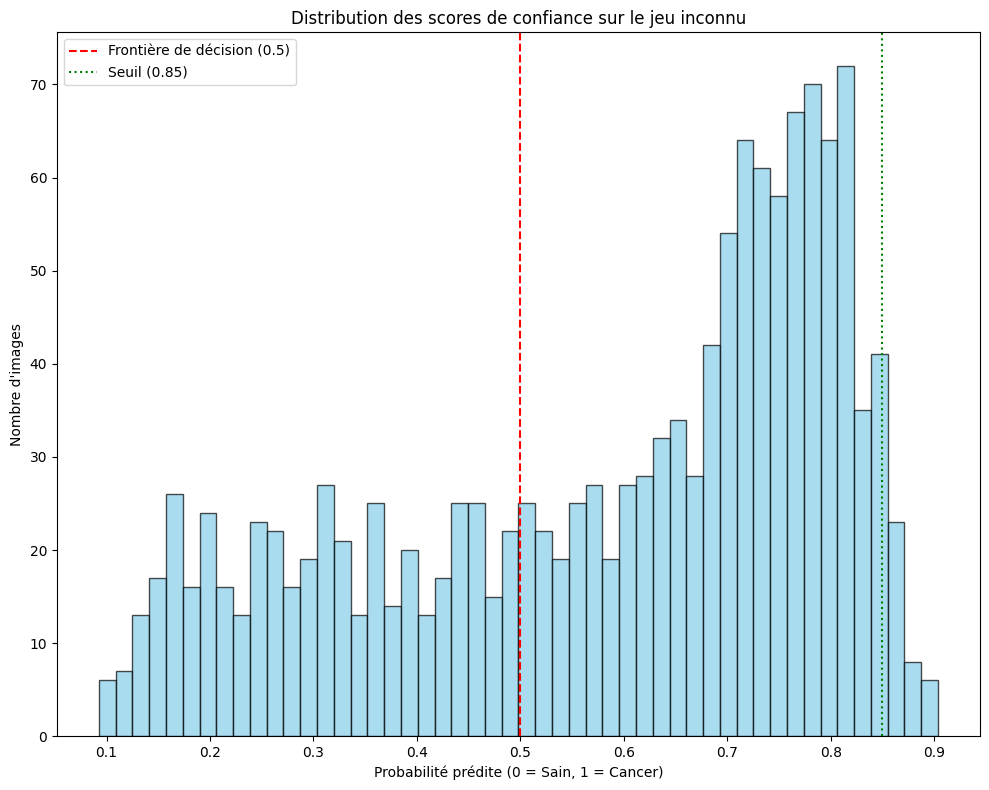

In [24]:
# from notebooks.utils.analyze_ssl import analyze_confidence
from notebooks.utils.plotting.make_model_plots import plot_confidence

new_trainer.model.load_state_dict(test_results['state_dict']) # Assure-toi que c'est la bonne clé
new_trainer.model.eval() 

all_unlabeled_probs = []
with torch.no_grad():
    for imgs, _, _ in uloader:
        logits = new_trainer.model(imgs.to(DEVICE))
        all_unlabeled_probs.extend(torch.sigmoid(logits).cpu().numpy().flatten())

all_unlabeled_probs = np.array(all_unlabeled_probs)

plot_confidence(
    probas=all_unlabeled_probs,# results['raw_data']['probs'],
    threshold=test_results['threshold'],#type:ignore
    stats=True,
    save_path=\
        SAVE_PATH/"figures",
        title_save=f"distrib_sans_label_ssl_{ssl_config['model']}"
)

In [25]:
matrix = plot_confusion_matrix(
    test_results['confusion_matrix'],
    save_path=SAVE_PATH/"figures",
    title_save=f"plot_confusion_matrix_ssl_{ssl_config['model']}"
)

plot_confusion_matrix_ssl_resnet18 sauvegardé dans /home/shipoz/Documents/OPENCLASSROOMS/P7/livrable_P7/datas/results/figures


La médiane montre qe le modèle a une tendance a prédire plus souvent des cancers (plus de 50% du set ont une proba supérieure a 0.65), il a une une forte incertitude sur 266 images (19%) et suppose que le jeu sans label est composée potentiellement de 8.3 cancers (environ 57%) et 24% de sain (337 images).

Le jeu serait donc plutot orienté sur des images de cancer. Cependant entre l'ece elevé et surtout le jeu de validation extrêmement faible, les performances sont a prendre avec des pincettes. De plus, la mise en avant de la métrique F2 et le ré équilibrage du critérion pendant le SSL, conduisent le modèle à porter une attention particulière sur les cancers ce qui explique sa plus grande confiance sur les cancers ET son classement.

In [26]:
del (test_results, all_unlabeled_probs, 
     trainer, model_classif, optimizer,
     new_model_classif, new_optimizer, new_trainer,
     udataset, uloader, test_loader, base_transform, 
     ssl_config, ssl_manager
    )
gc.collect()

17